In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import IBMQ, assemble
from qiskit.pulse import DriveChannel

import qiskit.ignis.verification.randomized_benchmarking as rb

In [2]:
# load IBMQ account and armonk backend
IBMQ.load_account()
armonk_real = IBMQ.providers()[1].backends.ibmq_armonk

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
# import function to modify int_map in the given backend
from functions.backend_modification  import mod_inst_map

In [4]:
# Randomized Benchmarking

# Prepare for RB
# set parameters
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 10

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1, 300, 10)
# nCliffs = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
print(len(nCliffs))

#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0]]

#Do three times as any 1Q Cliffords
length_multiplier = 1

rb_opts = {'length_vector': nCliffs,
           'nseeds': nseeds,
           'rb_pattern': rb_pattern,
           'group_gates': 'Clifford'}

# Create circuits for RB
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

30


In [5]:
# RB with stretch factor
# Since the inst_map in backend change intermediately after modify, we apply multiplier
# instead of original stretch factor
cr_list = [1, 2, 2]
c_list = [cr_list[0]]
for i in range(len(cr_list)-1):
    c_list.append(cr_list[i]*cr_list[i+1])
print('Stretch factor is ', c_list)


Stretch factor is  [1, 2, 4]


Cj =  1
Original Parameters
[{'duration': 640, 'amp': (0.3188161805637563-0.010462496940180532j), 'sigma': 160, 'beta': -4.696427683759619}]
Modified Parameters
[{'duration': 640, 'amp': (0.3188161805637563-0.010462496940180532j), 'sigma': 160, 'beta': -4.696427683759619}]
Compiling seed 0
Simulating seed 0
Job ID 5f70b9ea855962001a852030
After seed 0, alpha: 0.999664, EPC: 0.000168
Compiling seed 1
Simulating seed 1
Job ID 5f70bb20900da4001a23b1f3
After seed 1, alpha: 0.999666, EPC: 0.000167
Compiling seed 2
Simulating seed 2
Job ID 5f70bc56900da4001a23b1ff
After seed 2, alpha: 0.999445, EPC: 0.000278
Compiling seed 3
Simulating seed 3
Job ID 5f70bd8bdf9501001ad2add7
After seed 3, alpha: 0.999587, EPC: 0.000206
Compiling seed 4
Simulating seed 4
Job ID 5f70bec0865c100019bb4603
After seed 4, alpha: 0.999557, EPC: 0.000221
Compiling seed 5
Simulating seed 5
Job ID 5f70bff9472af200195e1681
After seed 5, alpha: 0.998636, EPC: 0.000682
Compiling seed 6
Simulating seed 6
Job ID 5f70c12f77b0

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/ass

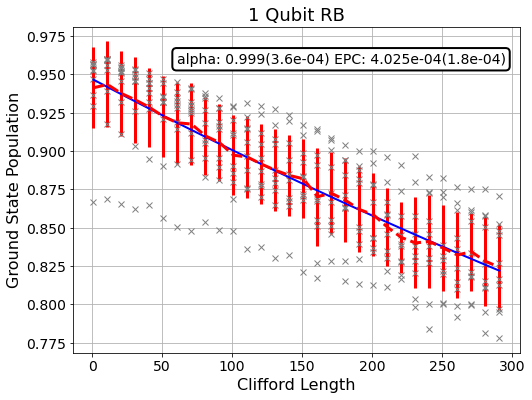

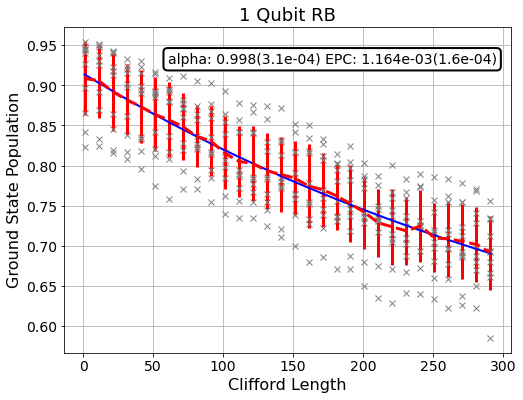

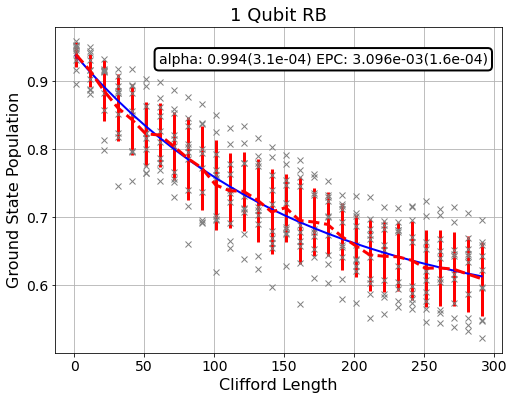

In [6]:
shots = 8192

# list store something helpful
transpiled_circs_list = []
rb_schedules_list = []
qobj_list = []
ydata = []
Fitter_list = []

for ci in cr_list:
    print('Cj = ', c_list[cr_list.index(ci)])
    # Apply the stretch factor into backend (modify inst_map of the backend)
    inst_map = armonk_real.defaults().instruction_schedule_map
    qubits = [0]
    dri_list = [DriveChannel(0)]
    mod_inst_map(inst_map, ci, qubits, dri_list)
    ydata_temp = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])

    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)

        # transpile circuit into the basis gate set of the backend
        transpiled_rb_circ_seed = qiskit.transpile(rb_circ_seed,
                                                   armonk_real,
                                                   initial_layout=[0],
                                                   basis_gates=armonk_real.configuration().basis_gates
                                                   )
        # store the transpiled circuits if need
        for i in range(nseeds):
            transpiled_circs_list.append(transpiled_rb_circ_seed[i])

        print('Simulating seed %d'%rb_seed)

        # # translate circuits into pulse through the inst_map in the backend
        # # (we have already modify the inst_map of the backend)
        rb_schedules = qiskit.schedule(transpiled_rb_circ_seed,
                                       armonk_real)
        # store the pulse schedules if need
        rb_schedules_list.append(rb_schedules)

        # combine the pulse schedules as an assemble
        rb_qobj = assemble(rb_schedules,
                           backend=armonk_real,
                           meas_level=2,
                           meas_return='avg',
                           shots=shots,
                           qubit_lo_freq=armonk_real.defaults().qubit_freq_est,
                           meas_lo_freq=armonk_real.defaults().meas_freq_est,
                           rep_time=armonk_real.configuration().rep_times)

        # store the rb_qobj if need
        qobj_list.append(rb_qobj)

        # implement the assemble on backend
        real_job = armonk_real.run(rb_qobj,
                                   job_tags=['RB_for_noise_error_mitigation'],
                                   job_name='RB_Cj=%.d_seed_%.d'%(ci, rb_seed),
                                   job_share_level='global')
        print('Job ID', real_job.job_id())

        # get the result of job
        rb_result = real_job.result()

        # Add mitigated data to the RB fitter
        rb_fit.add_data(rb_result)

        print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        ydata_temp.append(rb_fit.ydata[0]['mean'])

    # plot data for each stretch factor c
    plt.figure(figsize=(8, 6), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    # Plot the essence by calling plot_rb_data
    rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    # Add title and label
    ax.set_title('%d Qubit RB'%nQ, fontsize=18)
    plt.show()

    # add data to the list
    ydata.append(ydata_temp)
    Fitter_list.append(rb_fit)

print('Finished running RB')

In [7]:
# Calculate the gamma constant for Richardson Extrapolation

def gamma_j(c_list_):
    gamma_list_ = []
    for c_index in range(len(c_list_)):
        gamma_temp = 1
        for m_a in range(c_index):
            gamma_temp *= c_list_[m_a]/(c_list_[c_index]-c_list_[m_a])
        for m_b in range(len(c_list_)-c_index-1):
            gamma_temp *= c_list_[m_b+c_index+1]/(c_list_[c_index]-c_list_[m_b+c_index+1])
        gamma_list_.append(gamma_temp)
    if len(c_list_)%2==0:
        gamma = np.array(gamma_list_)*(-1)
    else:
        gamma = np.array(gamma_list_)
    return gamma

# gamma_1 with first two stretch factors and gamma_2 calculate from first 3 stretch factors.


gamma_list = [gamma_j(c_list[0:2]), gamma_j(c_list[0:3])]
for i in range(2):
    print('Gamma', i+1)
    print('c = ', c_list[0:2+i])
    print('gamma = ', gamma_list[i])
    # Check the constant didn't obey the constraint
    # (Summation of gamma_j = 1)
    # (Summation of gamma_j * c_j**k (k from 1 to n) = 0)
    print('check constraints')
    print('j from 0 to n = ', len(c_list[0:2+i])-1)
    print('Summation of gamma_j = ',sum(gamma_list[i]))
    rc = 0
    for j in range(len(c_list[0:2+i])-1):
        for k in range(len(gamma_list[i])):
            rc += c_list[0:2+i][k]**(j+1)*gamma_list[i][k]
    print('Summation of gamma_j * c_j**(from 1 to n) = ', rc)

Gamma 1
c =  [1, 2]
gamma =  [ 2. -1.]
check constraints
j from 0 to n =  1
Summation of gamma_j =  1.0
Summation of gamma_j * c_j**(from 1 to n) =  0.0
Gamma 2
c =  [1, 2, 4]
gamma =  [ 2.66666667 -2.          0.33333333]
check constraints
j from 0 to n =  2
Summation of gamma_j =  0.9999999999999998
Summation of gamma_j * c_j**(from 1 to n) =  -8.881784197001252e-16


In [8]:
# calculate extrapolation result
ext_data = np.zeros([2, len(ydata[0][-1])])
for i in range(len(ext_data)):
    for j in range(len(ext_data[i])):
        ext_temp = 0
        for k in range(len(c_list[0:2+i])):
            ext_temp += gamma_list[i][k]*ydata[k][-1][j]
        ext_data[i][j] = ext_temp
# print(ext_data)

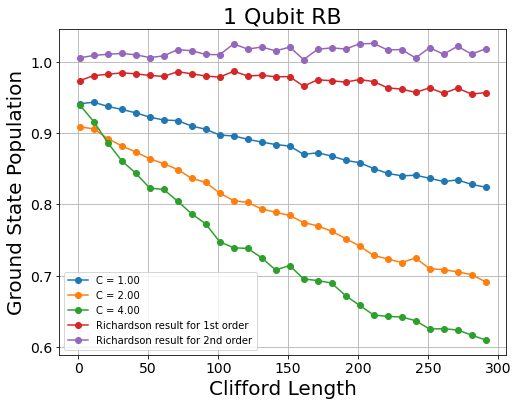

In [11]:
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('%d Qubit RB'%nQ, fontsize=22)
plt.xlabel('Clifford Length', fontsize=20)
plt.ylabel('Ground State Population', fontsize=20)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.grid()
for i in range(len(c_list)):
    plt.plot(xdata[0], ydata[i][-1], '-o', label='C = %.2f'%c_list[i])

plt.plot(xdata[0], ext_data[0], '-o', label = 'Richardson result for 1st order')
plt.plot(xdata[0], ext_data[1], '-o', label = 'Richardson result for 2nd order')
plt.legend()
plt.savefig('figures/Richardson_RB.jpg', transparent=True)

plt.show()